In [1]:
import Pkg
Pkg.activate("packages")
using CSV, DataFrames, Plots, Plots.PlotMeasures, StatsPlots, Statistics

  Activating environment at `~/Documents/Still evolving/Quantifying-SIM/packages/Project.toml`
┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1342
┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1342
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1342


### Figure 2: Quantification of the accuray and precision of our inference method using simulated mutant count data

In [92]:
# Reading the (true) input parameters
p = "range_mu-inc"
p2 = "range_switching"
true_para_1 = DataFrame(CSV.File("input_parameters/"*p*".csv"))
true_para_2 = DataFrame(CSV.File("input_parameters/"*p2*".csv"))
range_para_1 = 10 .^ collect(true_para_1.r_start[1]:true_para_1.r_increment[1]:true_para_1.r_end[1]) / true_para_1.divisions_off[1]
range_para_2 = 10 .^ collect(true_para_2.r_start[1]:true_para_2.r_increment[1]:true_para_2.r_end[1]) / true_para_1.divisions_off[1]
J1 = length(range_para_1)
J2 = length(range_para_2)
mu_off_true = true_para_1.mutations_off[1] / true_para_1.divisions_off[1];

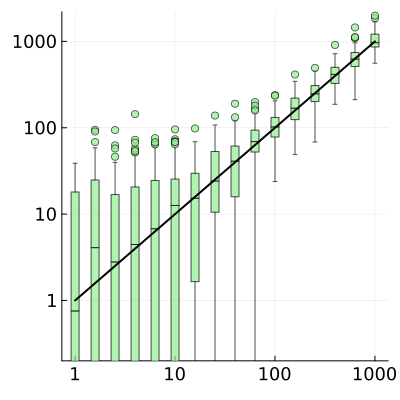

In [94]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Estimated compared to true mutation-rate increase for switching=0.01
m = "het_zero_div"
P_inc = plot(size=(400,400))
r = 11
for j1 = 1:2:J1
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/switch_$r/"*m*"_$j1.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc, [j1], inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off, lab="", c=:lightgreen, alpha=0.7)
end
plot!(P_inc, xticks=(collect(1:10:J1), Int.(range_para_1[1:10:J1])), yticks=(Int.(range_para_1[1:10:J1]), Int.(range_para_1[1:10:J1])), yscale=:log10, ylim=(0.2, 2200), tickfontsize=12)
plot!(range_para_1, c=:black, width=2, lab="")
#plot!(ylab="Estimated mutation-rate increase", xlab="True mutation-rate increase", title="Relative switching rate = $(round(range_para_2[r], digits=3))")

In [252]:
# Determining numerical values for the precision
i = 21
inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/switch_$r/"*m*"_$i.csv")), :AIC => ByRow(a->!isinf(a)))
println("True mutation-rate increase = ", range_para_1[i])
println("25 and 75 percent quantiles: ", quantile(inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off, [0.25,0.75])/ range_para_1[i])
println("")
i = 14
inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/switch_$r/"*m*"_$i.csv")), :AIC => ByRow(a->!isinf(a)))
println("True mutation-rate increase = ", range_para_1[i])
q2, q4 = quantile(inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off, [0.25, 0.75])
IQR = q4 - q2
println("Maximum estimated mutation-rate = ", maximum((inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off)[inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off .< q4 + 1.5*IQR]))

True mutation-rate increase = 100.0
25 and 75 percent quantiles: [0.7803450056982675, 1.3151145797549182]

True mutation-rate increase = 19.952623149688797
Maximum estimated mutation-rate = 89.053720167728


In [253]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Relative error and coefficient of variation across the estimates
m = "het_zero_div"
RE_alpha_mu = Matrix{Float64}(undef, (J2, J1))
CV_alpha_mu = Matrix{Float64}(undef, (J2, J1))
for j2 = 1:J2
    p_folder = "/switch_$j2"
    for j1 = 1:J1
        inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*p_folder*"/"*m*"_$j1.csv")), :AIC => ByRow(a->!isinf(a)))
        RE_alpha_mu[j2, j1] = (median(inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off) - range_para_1[j1]) / range_para_1[j1]
        CV_alpha_mu[j2, j1] = std(inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off) / mean(inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off)
    end
end

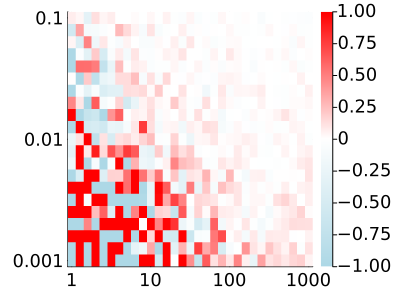

In [259]:
c_max = 1
c_min = -1
P_RE = plot(size=(400,300), rightmargin=10mm)
heatmap!(RE_alpha_mu, c=cgrad([:lightblue,:white,:red], [0,-c_min/(c_max-c_min),1]), clim=(c_min, c_max))
plot!(xticks=(collect(1:10:J1), Int.(range_para_1[1:10:J1])), yticks=(collect(1:10:J2), range_para_2[1:10:J2]), tickfontsize=12)
#plot!(title="Relative error (median)", xlab="Mutation-rate increase", ylab="Relative switching rate")

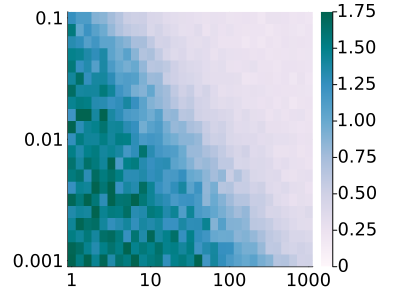

In [261]:
P_CV = plot(size=(400,300), rightmargin=10mm)
heatmap!(CV_alpha_mu, fill=true, levels=8, c=:PuBuGn_8, clim=(0, 1.75))
plot!(xticks=(collect(1:10:J1), Int.(range_para_1[1:10:J1])), yticks=(collect(1:10:J2), range_para_2[1:10:J2]), tickfontsize=12)
#plot!(title="Coefficient of variation", xlab="Mutation-rate increase", ylab="Relative switching rate")

In [262]:
savefig(P_inc, "figures/Figure_2A.pdf")
savefig(P_RE, "figures/Figure_2B.png")
savefig(P_CV, "figures/Figure_2C.png")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM/figures/Figure_2C.png"

### Figure 3: Impact of cell death on the estimation of the mutation-rate increase

In [2]:
# Reading the (true) input parameters
p = "range_death-off_switch-5"
p2 = "range_death-on_switch-5"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) / true_para.divisions_off[1]
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1];

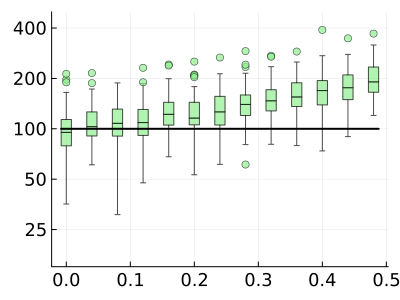

In [4]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Only response-off cells are affected by cell death
m = "het_zero_div"
P_inc_off = plot(size=(400,300))
r = 1
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/death-on_$r/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc_off, [j], inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off, lab="", c=:lightgreen, alpha=0.7)
end
plot!(P_inc_off, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, yticks=([25,50,100,200,400], [25,50,100,200,400]), ylim=(15,500))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=12)
#plot!(title="Only response-off cells affected", xlab="Extinction probability", ylab="Estimated mutation-rate increase")


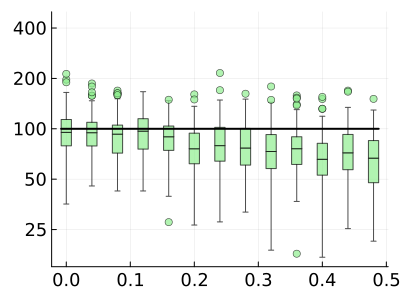

In [6]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Only response-on cells are affected by cell death
m = "het_zero_div"
P_inc_on = plot(size=(400,300))
r = 1
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/death-on_$j/"*m*"_$r.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc_on, [j], inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off, lab="", c=:lightgreen, alpha=0.7)
end
plot!(P_inc_on, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, yticks=([25,50,100,200,400], [25,50,100,200,400]), ylim=(15,500))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=12)
#plot!(title="Only response-on cells affected", xlab="Extinction probability", ylab="Estimated mutation-rate increase")


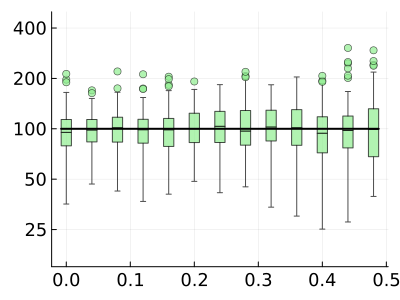

In [7]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# All cells are affected by cell death equally
m = "het_zero_div"
P_inc_all = plot(size=(400,300))
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/death-on_$j/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc_all, [j], inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off, lab="", c=:lightgreen, alpha=0.7)
end
plot!(P_inc_all, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, yticks=([25,50,100,200,400], [25,50,100,200,400]), ylim=(15,500))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=12)
#plot!(title="All cells affected equally", xlab="Extinction probability", ylab="Estimated mutation-rate increase")


In [8]:
savefig(P_inc_off, "figures/Figure_3A.pdf")
savefig(P_inc_on, "figures/Figure_3B.pdf")
savefig(P_inc_all, "figures/Figure_3C.pdf")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM/figures/Figure_3C.pdf"

#### Appendix Figure: Impact of cell death for different switching rates

In [44]:
# Reading the (true) input parameters
# Switching rate = 0.01 and 0.05
p_1 = "range_death-off_switch-1"
p2_1 = "range_death-on_switch-1"
p_5 = "range_death-off_switch-5"
p2_5 = "range_death-on_switch-5"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) / true_para.divisions_off[1]
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1];

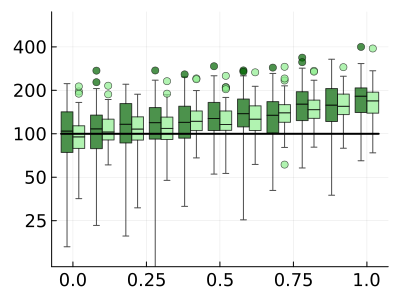

In [45]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Only response-off cells are affected by cell death
m = "het_zero_div"
P_inc_off_A = plot(size=(400,300))
r = 1
for j = 1:2:J
    inferred_para_1 = subset(DataFrame(CSV.File("inferred_parameters/"*p_1*"/death-on_$r/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc_off_A, [j-0.4], inferred_para_1.mutation_rate_on ./ inferred_para_1.mutation_rate_off, lab="", c=:darkgreen, alpha=0.7)
    inferred_para_5 = subset(DataFrame(CSV.File("inferred_parameters/"*p_5*"/death-on_$r/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc_off_A, [j+0.4], inferred_para_5.mutation_rate_on ./ inferred_para_5.mutation_rate_off, lab="", c=:lightgreen, alpha=0.7)
end
plot!(P_inc_off_A, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, yticks=([25,50,100,200,400], [25,50,100,200,400]), ylim=(12,700))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=12)
#plot!(title="Only response-off cells affected", xlab="Extinction probability", ylab="Estimated mutation-rate increase", legend=:bottomright)
#scatter!([0], [1], lab="Switching rate = 0.01", c=:darkgreen, alpha=0.7, marker=:square)
#scatter!([0], [1], lab="Switching rate = 0.05", c=:lightgreen, alpha=0.7, marker=:square)

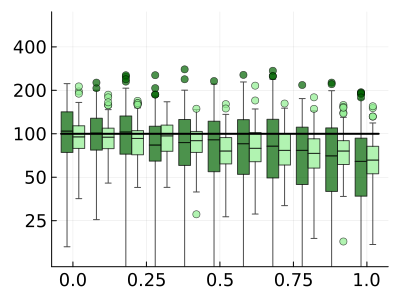

In [46]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Only response-on cells are affected by cell death
m = "het_zero_div"
P_inc_on_A = plot(size=(400,300))
r = 1
for j = 1:2:J
    inferred_para_1 = subset(DataFrame(CSV.File("inferred_parameters/"*p_1*"/death-on_$j/"*m*"_$r.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc_on_A, [j-0.4], inferred_para_1.mutation_rate_on ./ inferred_para_1.mutation_rate_off, lab="", c=:darkgreen, alpha=0.7)
    inferred_para_5 = subset(DataFrame(CSV.File("inferred_parameters/"*p_5*"/death-on_$j/"*m*"_$r.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc_on_A, [j+0.4], inferred_para_5.mutation_rate_on ./ inferred_para_5.mutation_rate_off, lab="", c=:lightgreen, alpha=0.7)
end
plot!(P_inc_on_A, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, yticks=([25,50,100,200,400], [25,50,100,200,400]), ylim=(12,700))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=12)
#plot!(title="Only response-on cells affected", xlab="Extinction probability", ylab="Estimated mutation-rate increase", legend=:topleft)
#scatter!([0], [1], lab="Switching rate = 0.01", c=:darkgreen, alpha=0.7, marker=:square)
#scatter!([0], [1], lab="Switching rate = 0.05", c=:lightgreen, alpha=0.7, marker=:square)

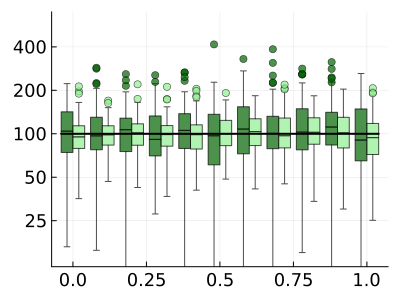

In [47]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# All cells are affected by cell death equally
m = "het_zero_div"
P_inc_all_A = plot(size=(400,300))
for j = 1:2:J
    inferred_para_1 = subset(DataFrame(CSV.File("inferred_parameters/"*p_1*"/death-on_$j/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc_all_A, [j-0.4], inferred_para_1.mutation_rate_on ./ inferred_para_1.mutation_rate_off, lab="", c=:darkgreen, alpha=0.7)
    inferred_para_5 = subset(DataFrame(CSV.File("inferred_parameters/"*p_5*"/death-on_$j/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc_all_A, [j+0.4], inferred_para_5.mutation_rate_on ./ inferred_para_5.mutation_rate_off, lab="", c=:lightgreen, alpha=0.7)
end
plot!(P_inc_all_A, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, yticks=([25,50,100,200,400], [25,50,100,200,400]), ylim=(12,700))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=12)
#plot!(title="All cells affected equally", xlab="Extinction probability", ylab="Estimated mutation-rate increase", legend=:topleft)
#scatter!([0], [1], lab="Switching rate = 0.01", c=:darkgreen, alpha=0.7, marker=:square)
#scatter!([0], [1], lab="Switching rate = 0.05", c=:lightgreen, alpha=0.7, marker=:square)

In [48]:
savefig(P_inc_off_A, "figures/Figure_A_2A.pdf")
savefig(P_inc_on_A, "figures/Figure_A_2B.pdf")
savefig(P_inc_all_A, "figures/Figure_A_2C.pdf")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM/figures/Figure_A_2C.pdf"

#### Appendix Figure: Impact of differential fitness of mutants on the estimation of the mutation-rate increase

In [39]:
# Reading the (true) input parameters
p = "range_fit-mut"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1])
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1];

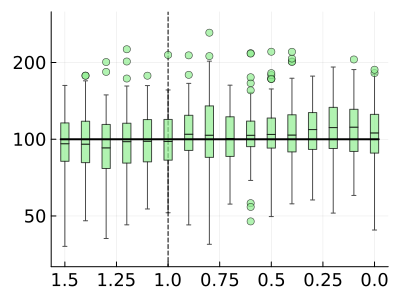

In [22]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
m = "het_zero_div"
P_inc_fit = plot(size=(400,300))
vline!([11], style=:dash, c=:black, lab="")
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc_fit, [j], inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off, lab="", c=:lightgreen, alpha=0.7)
end
plot!(P_inc_fit, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(10^1.5, 10^2.5), yticks=([50,100,200], [50,100,200]))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=12)
#plot!(xlab="Differential fitness mutants", ylab="Estimated mutation-rate increase")

In [23]:
savefig(P_inc_fit, "figures/Figure_A_3.pdf")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM/figures/Figure_A_3.pdf"

### Figure 4: Estimation when response-on cells have a non-zero division rate.

In [41]:
# Reading the (true) input parameters
p = "range_rel-div-on"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) / true_para.divisions_off[1]
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1];


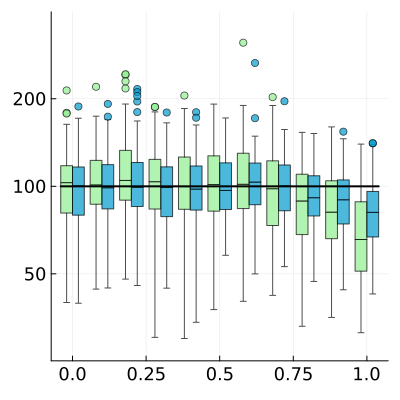

In [50]:
# Reading and plotting the inferred parameters
# Estimation methods: heterogeneous-response model, known f_on and
# (i) setting the rel. division rate to zero
# (ii) inferring the rel. division rate
# Estimated compared to true mutation-rate increase 
m_1 = "het_zero_div"
m_2 = "het_infer_div"
P_inc_div = plot(size=(400,400))
for j = 1:2:J
    inferred_para_1 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_1*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    inferred_para_2 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_2*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc_div, [j-0.4], inferred_para_1.mutation_rate_on ./ inferred_para_1.mutation_rate_off, lab="", c=:lightgreen, alpha=0.7)
    boxplot!(P_inc_div, [j+0.4], inferred_para_2.mutation_rate_on ./ inferred_para_2.mutation_rate_off, lab="", c=:deepskyblue3, alpha=0.7)
end
plot!(P_inc_div, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(10^1.4, 10^2.6), yticks=([50,100,200], [50,100,200]))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=12)
#plot!(xlab="Rel. division rate of response-on cells", ylab="Estimated mutation-rate increase")
#scatter!([0], [1], lab="Set rel. division to 0", c=:lightgreen, alpha=0.7, marker=:square)
#scatter!([0], [1], lab="Infer rel. division", c=:deepskyblue3, alpha=0.7, marker=:square)

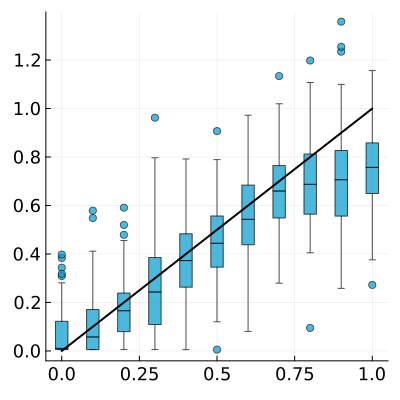

In [53]:
# Reading and plotting the inferred parameters
# Estimation methods: heterogeneous-response model, inferring the rel. division rate, known f_on
# Estimated compared to true rel. division rate of response-on cells
m = "het_infer_div"
P_div = plot(size=(400,400))
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_div, [j], inferred_para.division_rate_on, lab="", c=:deepskyblue3, alpha=0.7, boxwidth=0.4)
end
plot!(P_div, xticks=(collect(1:5:J), range_para[1:5:J]))#, ylim=(10^1.4, 10^2.6), yticks=([50,100,200], [50,100,200]))
plot!(collect(1:J), range_para, lab="", c=:black, width=2, tickfontsize=12)
#plot!(xlab="True rel. division rate", ylab="Estimated rel. division rate")

In [54]:
savefig(P_inc_div, "figures/Figure_4A.pdf")
savefig(P_div, "figures/Figure_4B.pdf")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM/figures/Figure_4B.pdf"

#### Appendix Figure: Estimation when response-on cells have a (known) non-zero division rate.

In [55]:
# Reading the (true) input parameters
p = "range_rel-div-on"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) / true_para.divisions_off[1]
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1];

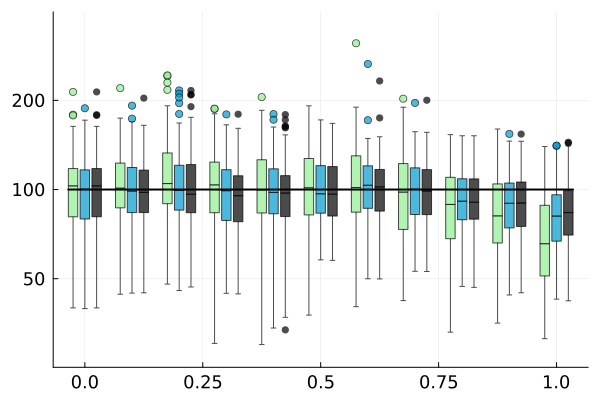

In [57]:
# Reading and plotting the inferred parameters
# Estimation methods: heterogeneous-response model, known f_on and
# (i) setting the rel. division rate to zero
# (ii) inferring the rel. division rate
# (iii) setting the rel. division rate to its true value
# Estimated compared to true mutation-rate increase 
m_1 = "het_zero_div"
m_2 = "het_infer_div"
m_3 = "het_set_div"
P_inc_div_A = plot(size=(600,400))
for j = 1:2:J
    inferred_para_1 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_1*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    inferred_para_2 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_2*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    inferred_para_3 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_3*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc_div_A, [j-0.5], inferred_para_1.mutation_rate_on ./ inferred_para_1.mutation_rate_off, lab="", c=:lightgreen, alpha=0.7, bar_width=0.4)
    boxplot!(P_inc_div_A, [j], inferred_para_2.mutation_rate_on ./ inferred_para_2.mutation_rate_off, lab="", c=:deepskyblue3, alpha=0.7, bar_width=0.4)
    boxplot!(P_inc_div_A, [j+0.5], inferred_para_3.mutation_rate_on ./ inferred_para_3.mutation_rate_off, lab="", c=:black, alpha=0.7, bar_width=0.4)
end
plot!(P_inc_div_A, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(10^1.4, 10^2.6), yticks=([50,100,200], [50,100,200]))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=12)
#plot!(xlab="Rel. division rate of response-on cells", ylab="Estimated mutation-rate increase")
#scatter!([0], [1], lab="Set rel. division to 0", c=:lightgreen, alpha=0.7, marker=:square)
#scatter!([0], [1], lab="Infer rel. division", c=:deepskyblue3, alpha=0.7, marker=:square)
#scatter!([0], [1], lab="Set rel. division to true value", c=:black, alpha=0.7, marker=:square)

In [58]:
savefig(P_inc_div_A, "figures/Figure_A_4.pdf")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM/figures/Figure_A_4.pdf"

### Figure 5: Model selection heterogeneous-response model - homogeneous-response model without differential fitness of mutants

In [59]:
# Reading the (true) input parameters
p = "range_rel-div-on"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) / true_para.divisions_off[1]
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1]
mu_mean_true = Vector{Float64}(undef, J)
for j = 1:J
    f_on = DataFrame(CSV.File("output_data/"*p*"/population_sizes_$j.csv")).value[2]
    mu_mean_true[j] = f_on * mu_on_true + (1-f_on)*mu_off_true
end
R = true_para.number_fluctuation_assays[1];
     

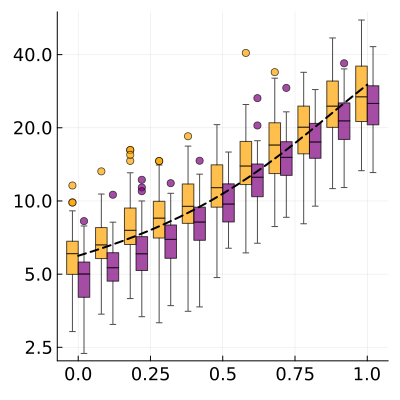

In [61]:
# Reading and plotting the inferred parameters
# Estimation methods:
# (i) Heterogeneous-response model with setting the rel. division rate to zero (unknown f_on)
# (ii) Homogeneous-response model with setting the fitness of mutants to one
# Estimated population-wide mutation-rate increase 
m_1 = "het_zero_div_unknown_fraction"
m_2 = "hom_no_fit"
P_mean = plot(size=(400,400))
for j = 1:2:J
    inferred_para_1 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_1*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    inferred_para_2 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_2*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_mean, [j-0.4], (inferred_para_1.mutation_rate_on .* inferred_para_1.fraction_on .+ inferred_para_1.mutation_rate_off .* (1 .- inferred_para_1.fraction_on)) ./ inferred_para_1.mutation_rate_off, lab="", c=:orange, alpha=0.7)
    boxplot!(P_mean, [j+0.4], inferred_para_2.mutation_rate_s ./ inferred_para_2.mutation_rate_p, lab="", c=:purple, alpha=0.7)
end
plot!(P_mean, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(2.2, 60), yticks=([2.5,5,10,20,40], [2.5,5,10,20,40]))
plot!(collect(1:J), mu_mean_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=12, style=:dash)
#plot!(xlab="Rel. division rate of response-on cells", ylab="Estimated mutation-rate increase")
#scatter!([0], [1], lab="Heterogeneous response", c=:orange, alpha=0.7, marker=:square)
#scatter!([0], [1], lab="Homogeneous response", c=:purple, alpha=0.7, marker=:square)

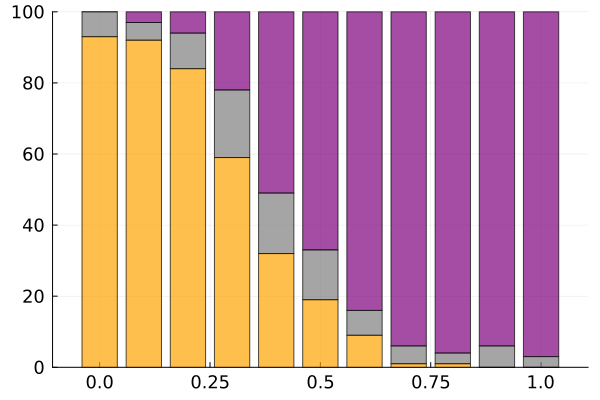

In [64]:
# Reading AIC values and selecting a model
# (i) Heterogeneous-response model with rel. division rate = zero 
# (ii) Homogeneous-response model with fitness of mutants = one
m_1 = "het_zero_div_unknown_fraction"
m_2 = "hom_no_fit"
select_het = Vector{Int}(undef, J)
select_hom = Vector{Int}(undef, J)
select_none = Vector{Int}(undef, J)
for j = 1:2:J
    AIC_1 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_1*"_$j.csv")).AIC
    AIC_2 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_2*"_$j.csv")).AIC
    AIC_diff = (AIC_1 .- AIC_2)
    select_het[j] = length(AIC_diff[AIC_diff .< -2])
    select_hom[j] = length(AIC_diff[AIC_diff .> 2])
    select_none[j] = R - select_het[j] - select_hom[j]
end
P_AIC = groupedbar([select_hom[1:2:J] select_none[1:2:J] select_het[1:2:J]], bar_position=:stack, c=[:purple :grey :orange], alpha=0.70, label=["" "" ""])#, label=["Homogeneous response (without differential fitness of mutants) selected" "No model selected" "Heterogeneous response (rel. division rate set to zero) selected"])
plot!(size=(600,400), xticks=(collect(1:2.5:J/2+1), range_para[1:5:J]), tickfontsize=12)
#plot!(xlab="Rel. division rate of response-on cells", ylab="Percentage", legend=:outertop)

In [65]:
savefig(P_mean, "figures/Figure_5A.pdf")
savefig(P_AIC, "figures/Figure_5B.pdf")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM/figures/Figure_5B.pdf"

### Figure 6: Model selection heterogeneous-response model - homogeneous-response model with differential fitness of mutants

In [66]:
# Reading the (true) input parameters
p = "range_rel-div-on"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) ./ true_para.divisions_off
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1]
mu_mean_true = Vector{Float64}(undef, J)
for j = 1:J
    f_on = DataFrame(CSV.File("output_data/"*p*"/population_sizes_$j.csv")).value[2]
    mu_mean_true[j] = f_on * mu_on_true + (1-f_on)*mu_off_true
end
R = true_para.number_fluctuation_assays[1]
     

100

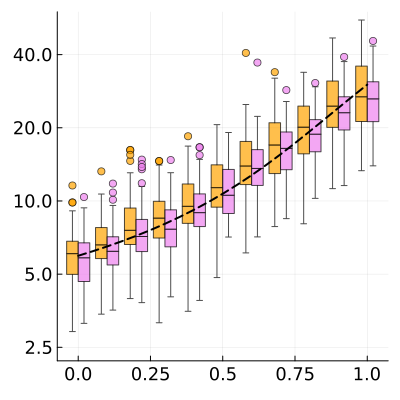

In [69]:
# Reading and plotting the inferred parameters
# Estimation methods:
# (i) Heterogeneous-response model with setting the rel. division rate to zero (unknown f_on)
# (ii) Homogeneous-response model with inferring the fitness of mutants under permissive/stressful conditions
# Estimated population-wide mutation-rate increase 
m_1 = "het_zero_div_unknown_fraction"
m_2 = "hom_infer_fit"
P_mean_fitm = plot(size=(400,400))
for j = 1:2:J
    inferred_para_1 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_1*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    inferred_para_2 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_2*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_mean_fitm, [j-0.4], (inferred_para_1.mutation_rate_on .* inferred_para_1.fraction_on .+ inferred_para_1.mutation_rate_off .* (1 .- inferred_para_1.fraction_on)) ./ inferred_para_1.mutation_rate_off[(inferred_para_1.AIC .!= Inf)], lab="", c=:orange, alpha=0.7)
    boxplot!(P_mean_fitm, [j+0.4], inferred_para_2.mutation_rate_s ./ inferred_para_2.mutation_rate_p, lab="", c=:violet, alpha=0.7)
end
plot!(P_mean_fitm, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(2.2, 60), yticks=([2.5,5,10,20,40], [2.5,5,10,20,40]))
plot!(collect(1:J), mu_mean_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=12, style=:dash)
#plot!(xlab="Rel. division rate of response-on cells", ylab="Estimated mutation-rate increase")
#scatter!([0], [1], lab="Heterogeneous response", c=:orange, alpha=0.7, marker=:square)
#scatter!([0], [1], lab="Homogeneous response", c=:violet, alpha=0.7, marker=:square)

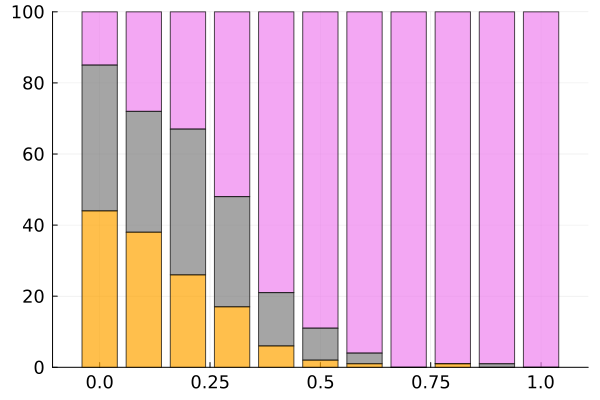

In [72]:
# Reading AIC values and selecting a model
# (i) Heterogeneous-response model with rel. division rate = zero 
# (ii) Homogeneous-response model with inferred fitnesses of mutants under permissive/stressful conditions
m_1 = "het_zero_div_unknown_fraction"
m_2 = "hom_infer_fit"
select_het = Vector{Int}(undef, J)
select_hom = Vector{Int}(undef, J)
select_none = Vector{Int}(undef, J)
for j = 1:2:J
    AIC_1 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_1*"_$j.csv")).AIC
    AIC_2 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_2*"_$j.csv")).AIC
    AIC_diff = (AIC_1 .- AIC_2)
    select_het[j] = length(AIC_diff[AIC_diff .< -2])
    select_hom[j] = length(AIC_diff[AIC_diff .> 2])
    select_none[j] = R - select_het[j] - select_hom[j]
end
P_AIC_fitm = groupedbar([select_hom[1:2:J] select_none[1:2:J] select_het[1:2:J]], bar_position=:stack, c=[:violet :grey :orange], alpha=0.7, label=["" "" ""])#, label=["Homogeneous response (with differential fitnesses of mutants) selected" "No model selected" "Heterogeneous response (rel. division rate set to zero) selected"])
plot!(size=(600,400), xticks=(collect(1:2.5:J/2+1), range_para[1:5:J]), tickfontsize=12)
#plot!(xlab="Rel. division rate of response-on cells", ylab="Percentage", legend=:outertop)

In [73]:
savefig(P_mean_fitm, "figures/Figure_6A.pdf")
savefig(P_AIC_fitm, "figures/Figure_6B.pdf")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM/figures/Figure_6B.pdf"

#### Appendix Figure: Comparing the homogeneous-response model (i) without, (ii) with joint, (iii) with separate differential fitness of mutants

In [74]:
# Reading the (true) input parameters
p = "range_rel-div-on"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) / true_para.divisions_off[1]
J = length(range_para)
R = true_para.number_fluctuation_assays[1];

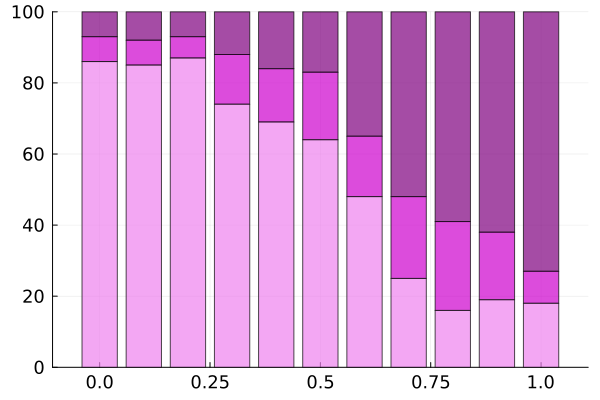

In [76]:
# Reading and comparing AIC values
# (i) Homogeneous-response model without differential fitness of mutants
# (ii) Homogeneous-response model with inferred joint fitness of mutants
# (iii) Homogeneous-response model with inferred fitnesses of mutants under permissive/stressful conditions
m_1 = "hom_no_fit"
m_2 = "hom_joint_fit"
m_3 = "hom_infer_fit"
select_1 = zeros(Int, J)
select_2 = zeros(Int, J)
select_3 = zeros(Int, J)
for j = 1:2:J
    AIC_1 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_1*"_$j.csv")).AIC
    AIC_2 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_2*"_$j.csv")).AIC
    AIC_3 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_3*"_$j.csv")).AIC
    AIC_1[isnan.(AIC_1)] .= Inf
    for i = 1:R
        if AIC_1[i] < AIC_2[i] 
            if AIC_1[i] < AIC_3[i]
                select_1[j] += 1
            else
                select_3[j] += 1
            end
        else
            if AIC_2[i] < AIC_3[i] 
                select_2[j] += 1
            else
                select_3[j] += 1
            end
        end 
    end
end
P_AIC_hom = groupedbar([select_1[1:2:J] select_2[1:2:J] select_3[1:2:J]], bar_position=:stack, c=[:purple :magenta3 :violet], alpha=0.7, label=["" "" ""])#, label=["Model without differential fitness of mutants has lowest AIC" "Model with joint differential fitness of mutants has lowest AIC" "Model with separate differential fitness of mutants has lowest"])
plot!(size=(600,400), xticks=(collect(1:2.5:J/2+1), range_para[1:5:J]), tickfontsize=12)
#plot!(xlab="Rel. division rate of response-on cells", ylab="Percentage", legend=:outertop)

In [77]:
savefig(P_AIC_hom, "figures/Figure_A_5.pdf")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM/figures/Figure_A_5.pdf"

### Appendix Figure: Testing the validity of the assumption that the response-on subpopulation can be treated deterministically

In [78]:
# Reading the (true) input parameters
p = "range_switching"
p2 = "range_rel-div-on"
true_para_1 = DataFrame(CSV.File("input_parameters/"*p*".csv"))
true_para_2 = DataFrame(CSV.File("input_parameters/"*p2*".csv"))
range_para_1 = 10 .^ collect(true_para_1.r_start[1]:true_para_1.r_increment[1]:true_para_1.r_end[1]) 
range_para_2 = collect(true_para_2.r_start[1]:true_para_2.r_increment[1]:true_para_2.r_end[1])
J1 = length(range_para_1)
J2 = length(range_para_2)
f0_on = [0., 0.01, 1.]
Nf = 10^9
N0 = true_para_1.initial_population_size[1]
div_off = true_para_1.divisions_off[1]
mu_off = true_para_1.mutations_off[1]
mu_on = true_para_1.mutations_on[1];

In [87]:
# Reading and plotting the output data
# Comparing with determinist equation for the size of the response-on subpopulation
include("population_dynamics.jl")
# Relative error and coefficient of variation across the simulations
RE_alpha_div_t1 = Matrix{Float64}(undef, (J2, J1))
CV_alpha_div_t1 = Matrix{Float64}(undef, (J2, J1))
RE_alpha_div_tf = Matrix{Float64}(undef, (J2, J1))
CV_alpha_div_tf = Matrix{Float64}(undef, (J2, J1))
f = 1
for j2 = 1:J2
    p_folder = "/rel-div_$j2"
    for j1 = 1:J1
        f0_on[end] = range_para_1[j1]/div_off
        N_on_t1 = DataFrame(CSV.File("output_data/"*p*p_folder*"/popsize_nm_on_t1_$j1.csv"))
        N_on_tf = DataFrame(CSV.File("output_data/"*p*p_folder*"/popsize_nm_on_tf_$j1.csv"))
        tf = t_final(N0, div_off-range_para_1[j1], Nf) 
        t1 = t_first_m(N0, div_off-range_para_1[j1], mu_off*(1-f0_on[f])+mu_on*f0_on[f])
        RE_alpha_div_t1[j2, j1] = (median(N_on_t1[:,f]) - pop_size(t1, N0*(1-f0_on[f]), div_off-range_para_1[j1], range_para_1[j1], N0*f0_on[f], range_para_2[j2])) / pop_size(t1, N0*(1-f0_on[f]), div_off-range_para_1[j1], range_para_1[j1], N0*f0_on[f], range_para_2[j2])
        RE_alpha_div_tf[j2, j1] = (median(N_on_tf[:,f]) - pop_size(tf, N0*(1-f0_on[f]), div_off-range_para_1[j1], range_para_1[j1], N0*f0_on[f], range_para_2[j2])) / pop_size(tf, N0*(1-f0_on[f]), div_off-range_para_1[j1], range_para_1[j1], N0*f0_on[f], range_para_2[j2])
        CV_alpha_div_t1[j2, j1] = std(N_on_t1[:,f]) / mean(N_on_t1[:,f])
        CV_alpha_div_tf[j2, j1] = std(N_on_tf[:,f]) / mean(N_on_tf[:,f])
    end
end

Initial fraction = 0.1

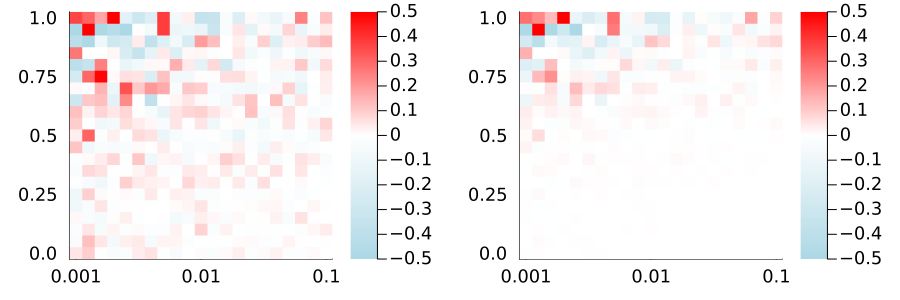

In [88]:
c_max = 0.5
c_min = -0.5
P_RE_t1 = plot(size=(400,300), rightmargin=5mm)
heatmap!(100 .*RE_alpha_div_t1, c=cgrad([:lightblue,:white,:red], [0,-c_min/(c_max-c_min),1]), clim=(c_min, c_max))
plot!(xticks=(collect(1:10:J1), range_para_1[1:10:J1]/div_off), yticks=(collect(1:5:J2), range_para_2[1:5:J2]/div_off), tickfontsize=12)
#plot!(title="Early time point", colorbar_title="Relative error in % (median)", xlab="Relative switching rate", ylab="Relative division rate", rightmargin=15mm)
P_RE_tf = plot(size=(400,300), rightmargin=5mm)
heatmap!(100 .*RE_alpha_div_tf, c=cgrad([:lightblue,:white,:red], [0,-c_min/(c_max-c_min),1]), clim=(c_min, c_max))
plot!(xticks=(collect(1:10:J1), range_para_1[1:10:J1]/div_off), yticks=(collect(1:5:J2), range_para_2[1:5:J2]/div_off), tickfontsize=12)
#plot!(title="Late time point", colorbar_title="Relative error in % (median)", xlab="Relative switching rate", ylab="Relative division rate", rightmargin=15mm)
print("Initial fraction = $(f0_on[f])")
plot(P_RE_t1, P_RE_tf,size=(900,300), bottommargin=5mm, leftmargin=3mm)

Initial fraction = 0.1

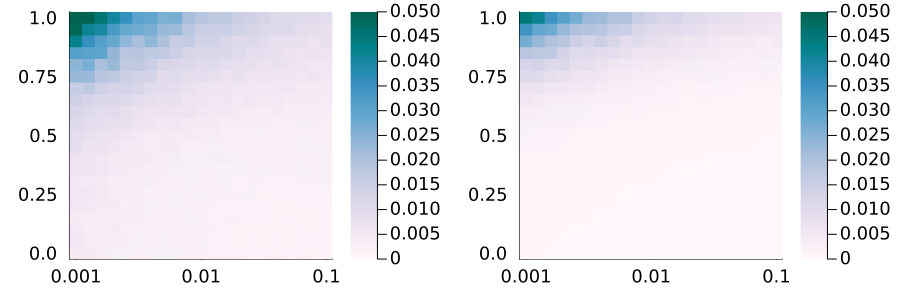

In [89]:
c_max = 0.05
P_CV_t1 = plot(size=(400,300), rightmargin=5mm)
heatmap!(CV_alpha_div_t1, fill=true, levels=8, c=:PuBuGn_8, clim=(0, c_max))
plot!(xticks=(collect(1:10:J1), range_para_1[1:10:J1]/div_off), yticks=(collect(1:5:J2), range_para_2[1:5:J2]/div_off), tickfontsize=12)
#plot!(title="Early time point", colorbar_title="Coefficient of variation", xlab="Relative switching rate", ylab="Relative division rate")
P_CV_tf = plot(size=(400,300), rightmargin=5mm)
heatmap!(CV_alpha_div_tf, fill=true, levels=8, c=:PuBuGn_8, clim=(0, c_max))
plot!(xticks=(collect(1:10:J1), range_para_1[1:10:J1]/div_off), yticks=(collect(1:5:J2), range_para_2[1:5:J2]/div_off), tickfontsize=12)
#plot!(title="Late time point", colorbar_title="Coefficient of variation", xlab="Relative switching rate", ylab="Relative division rate")
print("Initial fraction = $(f0_on[f])")
plot(P_CV_t1, P_CV_tf,size=(900,300), bottommargin=5mm, leftmargin=3mm)

In [90]:
savefig(P_RE_t1, "figures/Figure_A_6A$f.png")
savefig(P_RE_tf, "figures/Figure_A_6B$f.png")
savefig(P_CV_t1, "figures/Figure_A_6C$f.png")
savefig(P_CV_tf, "figures/Figure_A_6D$f.png")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM/figures/Figure_A_6D3.png"